In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2025-07-17 06:01:29.487469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load model #####

CNN_model = load_model("/root/data/model_CNN_v1.h5")

##### load image data #####

image_path = "/root/data/test_data_image.h5"
image_file = h5py.File(image_path, 'r')
print(image_file.keys())

sig_image = image_file['sig_image'][:]
ttbarBG_image = image_file['ttbarBG_image'][:]
jjBG_image = image_file['jjBG_image'][:]
jjBG_iht_image = image_file['jjBG_iht'][:]

print("signal length", len(sig_image))
print("ttbarBG length", len(ttbarBG_image))
print("jjBG length", len(jjBG_image))
print("jjBG_iht length", len(jjBG_iht_image))

print("Time:", time.time()-t1)

2025-07-17 06:01:32.378793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-07-17 06:01:32.379569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


<KeysViewHDF5 ['jjBG_iht', 'jjBG_image', 'sig_image', 'ttbarBG_image']>
signal length 102879
ttbarBG length 50065
jjBG length 1033
jjBG_iht length 21691
Time: 7.827935218811035


In [3]:
##### predict test data #####

sig_predict = CNN_model.predict(sig_image)
ttbarBG_predict = CNN_model.predict(ttbarBG_image)
jjBG_predict = CNN_model.predict(jjBG_image)
jjBG_iht_predict = CNN_model.predict(jjBG_iht_image)

2025-07-17 06:01:41.739590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


  76/3215 [..............................] - ETA: 6s 

2025-07-17 06:01:42.463642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


678/678 [==============================] - 1s 2ms/step


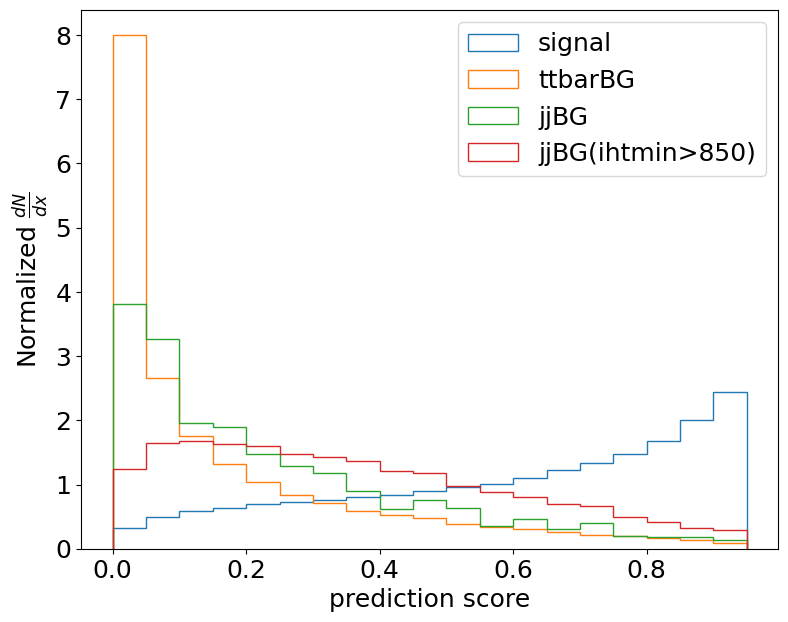

In [4]:
##### plot the prediction histogram #####

plt.figure(1, figsize=(9,7))
bins = np.arange(0,1,0.05)
plt.hist(sig_predict, bins=bins, label="signal", histtype='step', density=True)
plt.hist(ttbarBG_predict, bins=bins, label="ttbarBG", histtype='step', density=True)
plt.hist(jjBG_predict, bins=bins, label="jjBG", histtype='step', density=True)
plt.hist(jjBG_iht_predict, bins=bins, label="jjBG(ihtmin>850)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"prediction score", fontsize=18)
plt.ylabel(r"Normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [6]:
##### CNN selection #####
score_cut = 0.9

sig_selected = len(sig_predict[np.where(sig_predict>score_cut)])
ttbarBG_selected = len(ttbarBG_predict[np.where(ttbarBG_predict>score_cut)])
jjBG_selected = len(jjBG_predict[np.where(jjBG_predict>score_cut)])
jjBG_iht_selected = len(jjBG_iht_predict[np.where(jjBG_iht_predict>score_cut)])

print(sig_selected, "signal event pass CNN score", score_cut, ", CNN selection rate:", sig_selected/len(sig_image))
print(ttbarBG_selected, "ttbarBG event pass CNN score", score_cut, ", CNN selection rate:", ttbarBG_selected/len(ttbarBG_image))
print(jjBG_selected, "jjBG event pass CNN score", score_cut, ", CNN selection rate:", jjBG_selected/len(jjBG_image))
print(jjBG_iht_selected, "jjBG_iht event pass CNN score", score_cut, ", CNN selection rate:", jjBG_iht_selected/len(jjBG_iht_image))

##### calculate significance in Luminosity = 3000(fb^-1) #####

N_sim_sig = 200000
N_sim_ttbarBG = 200000
N_sim_jjBG = 200000
N_sim_jjBG_iht = 1000000

Xsection_sig = 1.1086583
print("Before selection, the cross section of signal:", Xsection_sig, "(fb)")
Xsection_ttbarBG = 34166.61
print("Before selection, the cross section of ttbarBG:", Xsection_ttbarBG, "(fb)")
Xsection_jjBG = 60561410.45
print("Before selection, the cross section of jjBG:", Xsection_jjBG, "(fb)")
Xsection_jjBG_iht = 1526881.328
print("Before selection, the cross section of jjBG_iht:", Xsection_jjBG_iht, "(fb)")

Luminosity = 3000    ### unit:fb^-1
print("\nIn Luminosity = 3000(fb^-1)")

s = Xsection_sig * (sig_selected/N_sim_sig) * Luminosity
b = Xsection_ttbarBG * (ttbarBG_selected/N_sim_ttbarBG) * Luminosity + Xsection_jjBG * (jjBG_selected/N_sim_jjBG) * Luminosity
significance = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
print("significance:", significance)

b_iht = Xsection_ttbarBG * (ttbarBG_selected/N_sim_ttbarBG) * Luminosity + Xsection_jjBG_iht * (jjBG_iht_selected/N_sim_jjBG_iht) * Luminosity
significance_iht = np.sqrt(2*((s+b_iht)*np.log(1+s/b_iht)-s))
print("significance (with jjBG iht>850):", significance_iht)

23193 signal event pass CNN score 0.9 , CNN selection rate: 0.22543959408625666
297 ttbarBG event pass CNN score 0.9 , CNN selection rate: 0.005932288025566763
10 jjBG event pass CNN score 0.9 , CNN selection rate: 0.00968054211035818
471 jjBG_iht event pass CNN score 0.9 , CNN selection rate: 0.02171407496196579
Before selection, the cross section of signal: 1.1086583 (fb)
Before selection, the cross section of ttbarBG: 34166.61 (fb)
Before selection, the cross section of jjBG: 60561410.45 (fb)
Before selection, the cross section of jjBG_iht: 1526881.328 (fb)

In Luminosity = 3000(fb^-1)
significance: 0.12690857784948192
significance (with jjBG iht>850): 0.2537794447787541
